# Fine-tuning an Object Detection Model on a custom dataset  
Video segments are shot by a Raspberry Pi 3 Model B equipped with a Raspberry Pi HQ Camera with a 16mm 10MP lens.  
[Raspberry Pi 3 Model B](https://www.raspberrypi.com/products/raspberry-pi-3-model-b/)  
[Raspberry Pi HQ Camera](https://www.raspberrypi.com/products/raspberry-pi-high-quality-camera/)  
[16mm 10MP lens](https://www.adafruit.com/product/4562)  
**Note:** This dataset contains many negative samples (no objects in image).  Since, we'd like our model to perform well on these images, they should be included in training.  See [1911](https://github.com/pytorch/vision/pull/1911) and [2069](https://github.com/pytorch/vision/pull/2069) for more information on training with negative samples.

### Data Exploration

In [1]:
import os

In [2]:
proj_dir = os.path.join('/home/mark/git', 'birdcam')

data_dir = os.path.join('/media/md0-raid1', 'birdcam_label')

Get a list of video paths in the directory

In [3]:
vids = [[f.name, f.path] for f in os.scandir(data_dir) if f.is_dir()]

In [4]:
vids

[['1663713946', '/media/md0-raid1/birdcam_label/1663713946']]

Image paths

In [5]:
imgs = []

for vid_id, vid_path in vids:
    for f in os.scandir(os.path.join(vid_path, 'JPEGImages')):
        if f.is_file():
            frame = f.name[6:-4]
            img_id = vid_id + '_' + frame
            imgs.append([img_id, f.path])

imgs = sorted(imgs, key=lambda img: img[0])
imgs = [img[1] for img in imgs]

In [6]:
imgs[:10]

['/media/md0-raid1/birdcam_label/1663713946/JPEGImages/frame_000000.PNG',
 '/media/md0-raid1/birdcam_label/1663713946/JPEGImages/frame_000001.PNG',
 '/media/md0-raid1/birdcam_label/1663713946/JPEGImages/frame_000002.PNG',
 '/media/md0-raid1/birdcam_label/1663713946/JPEGImages/frame_000003.PNG',
 '/media/md0-raid1/birdcam_label/1663713946/JPEGImages/frame_000004.PNG',
 '/media/md0-raid1/birdcam_label/1663713946/JPEGImages/frame_000005.PNG',
 '/media/md0-raid1/birdcam_label/1663713946/JPEGImages/frame_000006.PNG',
 '/media/md0-raid1/birdcam_label/1663713946/JPEGImages/frame_000007.PNG',
 '/media/md0-raid1/birdcam_label/1663713946/JPEGImages/frame_000008.PNG',
 '/media/md0-raid1/birdcam_label/1663713946/JPEGImages/frame_000009.PNG']

Label names  
There are only two labels: bird & none

In [7]:
id2label = {0: 'none', 1: 'bird'}
label2id = {v: k for k, v in id2label.items()}

Image labels & bounding boxes

In [8]:
import xml.etree.ElementTree as ET

labels, bboxes = [], []

for vid_id, vid_path in vids:
    for f in os.scandir(os.path.join(vid_path, 'Annotations')):
        if f.is_file():
            frame = f.name[6:-4]
            img_id = vid_id + '_' + frame
            root = ET.parse(f.path).getroot()
            children = [child.tag for child in root]
            if 'object' in children:
                label = root[5][0].text
                xmin, ymin, xmax, ymax = [round(float(e.text)) for e in root[5][4][:4]]
                bbox = [xmin, ymin, xmax-xmin, ymax-ymin]
            else:
                label = 'none'
                bbox = [0, 0, 0, 0]
            label_id = label2id[label]
            labels.append([img_id, label_id])
            bboxes.append([img_id, bbox])
labels = sorted(labels, key=lambda label: label[0])
labels = [label[1] for label in labels]
bboxes = sorted(bboxes, key=lambda bbox: bbox[0])
bboxes = [bbox[1] for bbox in bboxes]

In [9]:
labels[:10]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [10]:
bboxes[:10]

[[963, 609, 208, 83],
 [961, 606, 203, 86],
 [959, 605, 203, 87],
 [954, 604, 208, 88],
 [948, 602, 219, 90],
 [946, 600, 216, 92],
 [945, 600, 214, 92],
 [944, 600, 213, 91],
 [944, 600, 213, 91],
 [943, 601, 215, 92]]

### View sample image

In [11]:
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle

In [12]:
img_idx = 0

img = plt.imread(imgs[img_idx])
bbox = bboxes[img_idx]
label = labels[img_idx]
label_name = id2label[labels[img_idx]]

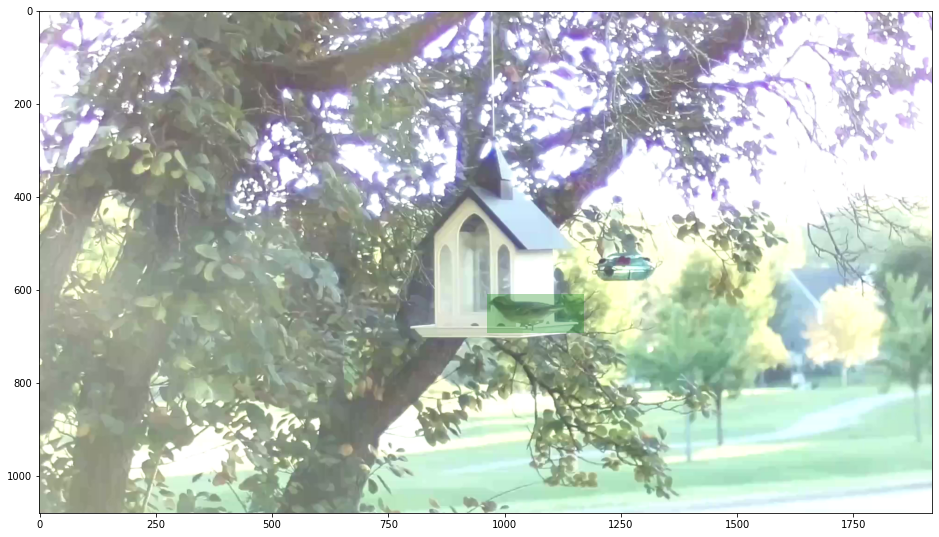

In [13]:
fig = plt.figure(1, figsize=(16, 12))
plt.imshow(img)

x, y, w, h = bbox
current_axis = plt.gca()
current_axis.add_patch(plt.Rectangle((x, y), w, h, facecolor='green', alpha=0.3))
plt.show()

### Create custom dataset

In [14]:
import torch
from PIL import Image

In [15]:
class BirdcamDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        
        self.vids = [[f.name, f.path] for f in os.scandir(self.root) if f.is_dir()]
        
        self.imgs = []
        for vid_id, vid_path in self.vids:
            for f in os.scandir(os.path.join(vid_path, 'JPEGImages')):
                if f.is_file():
                    frame = f.name[6:-4]
                    img_id = vid_id + '_' + frame
                    self.imgs.append([img_id, f.path])
        self.imgs = sorted(self.imgs, key=lambda img: img[0])
        self.imgs = [img[1] for img in self.imgs]
        
        self.id2label = {0: 'none', 1: 'bird'}
        self.label2id = {v: k for k, v in id2label.items()}
        self.n_classes = len(self.id2label)
        
        self.labels, self.bboxes = [], []
        for vid_id, vid_path in self.vids:
            for f in os.scandir(os.path.join(vid_path, 'Annotations')):
                if f.is_file():
                    frame = f.name[6:-4]
                    img_id = vid_id + '_' + frame
                    root = ET.parse(f.path).getroot()
                    children = [child.tag for child in root]
                    if 'object' in children:
                        label = root[5][0].text
                        xmin, ymin, xmax, ymax = [round(float(e.text)) for e in root[5][4][:4]]
                        bbox = [xmin, ymin, xmax, ymax]
                    else:
                        label = 'none'
                        bbox = [0, 0, 1, 1]
                    label_id = label2id[label]
                    self.labels.append([img_id, label_id])
                    self.bboxes.append([img_id, bbox])
        self.labels = sorted(self.labels, key=lambda label: label[0])
        self.labels = [label[1] for label in self.labels]
        self.bboxes = sorted(self.bboxes, key=lambda bbox: bbox[0])
        self.bboxes = [bbox[1] for bbox in self.bboxes]
                
    def __getitem__(self, idx):
        img_path = self.imgs[idx]
        img = Image.open(img_path).convert('RGB')
        
        box = torch.tensor(self.bboxes[idx], dtype=torch.float32)
        boxes = box[None, :]
        
        labels = torch.tensor([self.labels[idx]], dtype=torch.int64)
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        
        iscrowd = torch.zeros((1,), dtype=torch.int64)
        
        target = {
            'boxes': boxes,
            'labels': labels,
            'image_id': torch.tensor([idx]),
            'area': area,
            'iscrowd': iscrowd
        }
        
        if self.transforms is not None:
            img, target = self.transforms(img, target)
            
        return img, target
    
    def __len__(self):
        return len(self.imgs)

In [16]:
birdcam_dataset = BirdcamDataset(root='/media/md0-raid1/birdcam_label')

In [17]:
birdcam_dataset.__len__()

1772

Show random sample of data

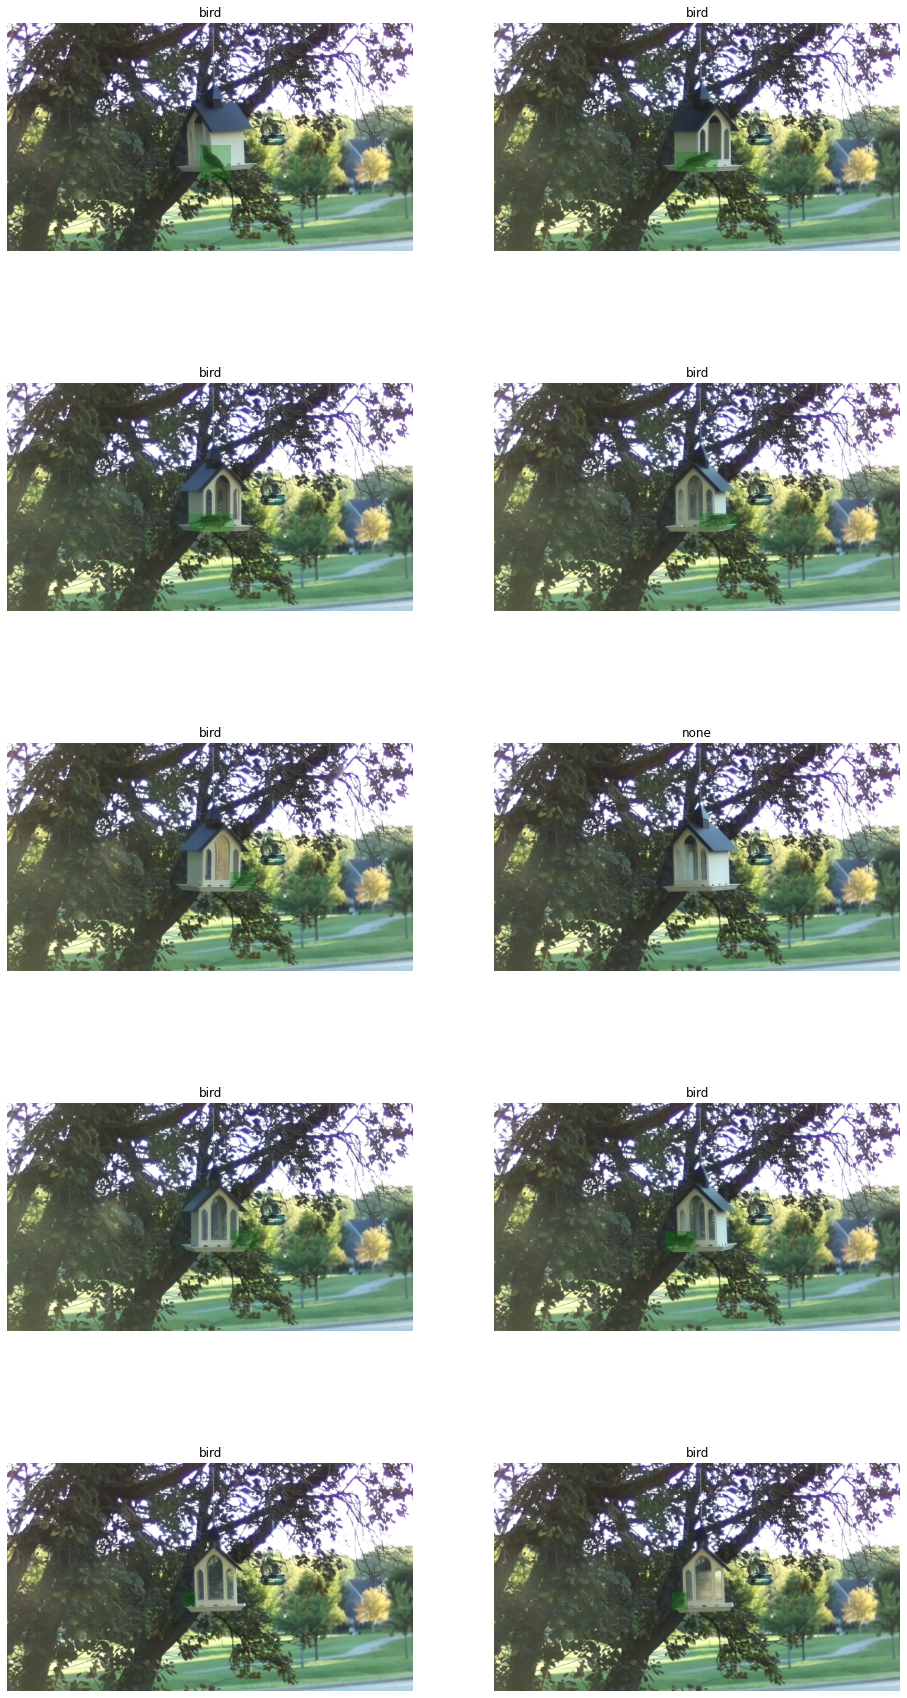

In [18]:
figure = plt.figure(figsize=(16, 32))
for i in range(1, 11):
    sample_idx = torch.randint(birdcam_dataset.__len__(), size=(1,)).item()
    img, target = birdcam_dataset[sample_idx]
    label = target['labels']
    xmin, ymin, xmax, ymax = target['boxes'][0]
    width = xmax - xmin
    height = ymax - ymin
    figure.add_subplot(5, 2, i)
    plt.title(birdcam_dataset.id2label[int(label[0])])
    plt.axis('off')
    plt.imshow(img)
    plt.gca().add_patch(Rectangle((xmin,ymin), width, height, facecolor='green', alpha=0.3))
plt.show()

### Finetuning from a pretrained model

In [19]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

Get pretrained model

In [20]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

/home/mark/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mark/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Replace pretrained head with a new one that has the correct number of classes

In [21]:
num_classes = birdcam_dataset.n_classes
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

### Train and evaluate
Single GPU

In [22]:
from birdcam.engine import train_one_epoch, evaluate
import birdcam.utils as utils
import birdcam.transforms as T

In [23]:
def get_transforms(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

Test forward method

In [24]:
dataset = BirdcamDataset(
        root='/media/md0-raid1/birdcam_label', 
        transforms=get_transforms(train=True)
    )
data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=2, shuffle=True, num_workers=4,
        collate_fn=utils.collate_fn
    )

images, targets = next(iter(data_loader))
images = [image for image in images]
targets = [{k: v for k, v in t.items()} for t in targets]
targets
# output = model(images, targets)
# model.eval()
# x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
# predictions = model(x)

[{'boxes': tensor([[1054.,  608., 1197.,  689.]]),
  'labels': tensor([1]),
  'image_id': tensor([1486]),
  'area': tensor([11583.]),
  'iscrowd': tensor([0])},
 {'boxes': tensor([[775., 603., 925., 706.]]),
  'labels': tensor([1]),
  'image_id': tensor([105]),
  'area': tensor([15450.]),
  'iscrowd': tensor([0])}]

In [25]:
output = model(images, targets)

In [26]:
output

{'loss_classifier': tensor(0.9726, grad_fn=<NllLossBackward0>),
 'loss_box_reg': tensor(0.1159, grad_fn=<DivBackward0>),
 'loss_objectness': tensor(0.0151, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 'loss_rpn_box_reg': tensor(0.0054, grad_fn=<DivBackward0>)}

In [27]:
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)

In [28]:
predictions

[{'boxes': tensor([[ 78.8350, 131.9315,  82.6525, 136.2161],
          [184.4690,  65.5392, 188.0900,  70.2552],
          [185.4888,  58.4452, 189.0809,  64.4596],
          [185.4838,  64.5279, 189.1672,  69.7146],
          [199.2392,  62.2149, 203.6908,  68.4836],
          [182.9205,  65.0697, 186.5848,  69.5193],
          [294.3420,  65.1723, 297.4159,  69.2588],
          [169.0187,  58.7100, 172.4509,  62.3800],
          [167.1340,  61.0827, 170.3082,  65.0975],
          [186.7712,  58.1761, 190.3873,  64.6803],
          [186.7498,  64.8951, 190.4331,  70.3039],
          [183.9931,  61.9920, 187.7927,  67.1842],
          [168.1643,  60.9325, 171.5840,  64.7416],
          [187.6337, 150.3553, 190.8126, 155.2551],
          [184.0214,  58.8301, 187.7479,  64.3913],
          [188.9380, 150.1243, 192.1619, 154.5309],
          [189.1159, 148.8537, 192.3303, 153.0471],
          [170.5314,  60.4972, 173.8503,  64.7793],
          [185.3673,  62.0849, 189.1796,  67.6782],
   

Get datasets

In [37]:
dataset = BirdcamDataset(
        root='/media/md0-raid1/birdcam_label', 
        transforms=get_transforms(train=True)
    )
dataset_val = BirdcamDataset(
        root='/media/md0-raid1/birdcam_label', 
        transforms=get_transforms(train=False)
    )

In [38]:
n_val = int(round(len(dataset) * .2))
n_val

354

Train/test split

In [39]:
torch.manual_seed(77)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-n_val])
dataset_val = torch.utils.data.Subset(dataset_val, indices[-n_val:])

Get dataloaders

In [40]:
data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=2, shuffle=True, num_workers=4, collate_fn=utils.collate_fn
    )
data_loader_val = torch.utils.data.DataLoader(
        dataset_val, batch_size=1, shuffle=False, num_workers=4, collate_fn=utils.collate_fn
    )

Get model

In [41]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

num_classes = birdcam_dataset.n_classes
in_features = model.roi_heads.box_predictor.cls_score.in_features

model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

Send model to GPU

In [42]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

Get optimizer and learning rate scheduler

In [43]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

Train and evaluate for 3 epochs

In [44]:
import datetime
import time

start_time = time.time()
num_epochs = 3
for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=1000)
    lr_scheduler.step()
    evaluate(model, data_loader_val, device=device)
total_time = time.time() - start_time
total_time_str = str(datetime.timedelta(seconds=int(total_time)))

print('Total training time: {}'.format(total_time_str))

Epoch: [0]  [  0/709]  eta: 0:10:30  lr: 0.000012  loss: 1.0458 (1.0458)  loss_classifier: 0.8498 (0.8498)  loss_box_reg: 0.1785 (0.1785)  loss_objectness: 0.0125 (0.0125)  loss_rpn_box_reg: 0.0050 (0.0050)  time: 0.8900  data: 0.6341  max mem: 5047
Epoch: [0]  [708/709]  eta: 0:00:00  lr: 0.005000  loss: 0.0437 (0.1427)  loss_classifier: 0.0138 (0.0398)  loss_box_reg: 0.0242 (0.0601)  loss_objectness: 0.0003 (0.0141)  loss_rpn_box_reg: 0.0011 (0.0287)  time: 0.2607  data: 0.0135  max mem: 5047
Epoch: [0] Total time: 0:03:03 (0.2595 s / it)
creating index...
index created!
Test:  [  0/354]  eta: 0:03:07  model_time: 0.0626 (0.0626)  evaluator_time: 0.0026 (0.0026)  time: 0.5292  data: 0.4436  max mem: 5047
Test:  [100/354]  eta: 0:00:17  model_time: 0.0503 (0.0506)  evaluator_time: 0.0016 (0.0015)  time: 0.0627  data: 0.0065  max mem: 5047
Test:  [200/354]  eta: 0:00:09  model_time: 0.0502 (0.0504)  evaluator_time: 0.0014 (0.0015)  time: 0.0622  data: 0.0066  max mem: 5047
Test:  [300/